In [43]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import MCMC, NUTS
from pyro import poutine
import pyro.distributions as dist
from pyro.infer.util import (
    torch_item,
)
from pyro.util import check_if_enumerated, warn_if_nan


In [ ]:
def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the ernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

In [45]:
def guide_zero(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    return pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

    
def guide_t(sample):
    # i think we have a problem here -> we get a fairness of 0.5 and it should actually be skewed towards heads based on the data
    nuts_kernel = NUTS(model)
    mcmc = MCMC(
        nuts_kernel,
        num_samples=1,
        warmup_steps=10,
        num_chains=1,
    )
    mcmc.run(sample)
    samples = mcmc.get_samples()
    return samples

In [46]:
# this should replace trace_elbo
def simple_elbo(model, guide_t, guide_zero,  *args, **kwargs):
    # run the guide and trace its execution
    guide_0_trace = poutine.trace(guide_zero).get_trace( *args, **kwargs)
    guide_t_trace = poutine.trace(guide_t).get_trace( *args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_t_trace)).get_trace( *args, **kwargs)
    
    # osntrative loss
    l_diff= (model_trace.log_prob_sum() - guide_0_trace.log_prob_sum()) - (model_trace.log_prob_sum() - guide_t_trace.log_prob_sum())
    l_vcd = l_diff +  guide_0_trace.log_prob_sum() - guide_t_trace.log_prob_sum()
    
    return -l_vcd

In [47]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 200

assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [48]:
# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(9):
    data.append(torch.tensor(1.0))
for _ in range(1):
    data.append(torch.tensor(0.0))

In [49]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide_t, optimizer, loss=simple_elbo)

Sample: 100%|███████████████████████████████████████████| 11/11 [00:00, 84.71it/s, step size=3.12e-01, acc. prob=0.907]


Sample: 100%|███████████████████████████████████████████| 11/11 [00:00, 66.01it/s, step size=5.20e-01, acc. prob=1.000]


Sample: 100%|███████████████████████████████████████████| 11/11 [00:00, 93.05it/s, step size=7.49e-01, acc. prob=0.003]


CPU times: total: 26.6 s
Wall time: 35.1 s


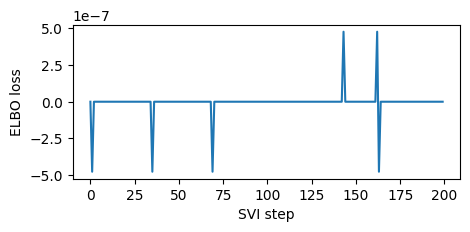

In [50]:
%%time
pyro.clear_param_store()
# These should be reset each training loop.

losses = []
for step in range(n_steps):  # Consider running for more steps.
    loss = svi.step(guide_zero, data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [52]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.500 +- 0.090


In [ ]:
# why is the loss so small? hmmm